## Evaluation dos Datasets Desbalanceados

In [41]:
from modified_knn_without_changes import KNNModifiedClassifier as KNNReferenceClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from modified_knn import KNNModifiedClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [42]:
def k_fold_cross_validation(X, y, model, n_test: int = 10) -> float:
    kf = KFold(n_splits=n_test)
    accuracies = []
    roc_auc = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        roc_auc.append(roc_auc_score(y_test, y_pred))

    return np.mean(accuracies), np.mean(roc_auc)


def k_fold_cross_validation_y_fix(X, y, model, n_splits: int = 10):
    kf = KFold(n_splits=n_splits)
    accuracies = []
    roc_aucs = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        if len(np.unique(y_test)) > 1:
            roc_aucs.append(roc_auc_score(y_test, y_pred))
        else:
            roc_aucs.append(np.nan)  # Append NaN if roc_auc_score cannot be computed

    mean_accuracy = np.mean(accuracies)
    mean_roc_auc = np.nanmean(roc_aucs)  # Compute mean ignoring NaN values
    return mean_accuracy, mean_roc_auc
    

def plot_confusion_matrix(y_true, y_pred, ax, labels=None, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

Instanciação de 3 KNN diferentes:
- sk_knn -> KNN do Scikit learn
- reference_knn -> KNN referência para modificação (https://github.com/rushter/MLAlgorithms/blob/master/mla/knn.py)
- modified_knn -> Modificação feitra em cima do reference_knn, utilizando o hiperparâmetro criado='correlations'

In [43]:
sk_knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
reference_knn = KNNReferenceClassifier(k=7, weight='distance')
modified_knn = KNNModifiedClassifier(k=7, weight='correlations')

### Evaluation do Dataset 9971

In [44]:
df = pd.read_csv('../csv_files/dataset_9971.csv')
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500.0,20.0,34.0,5.9,1.6,0.37,2
579,40,Male,0.6,0.1,98.0,35.0,31.0,6.0,3.2,1.10,1
580,52,Male,0.8,0.2,245.0,48.0,49.0,6.4,3.2,1.00,1
581,31,Male,1.3,0.5,184.0,29.0,32.0,6.8,3.4,1.00,1


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      583 non-null    int64  
 1   V2      583 non-null    object 
 2   V3      583 non-null    float64
 3   V4      583 non-null    float64
 4   V5      583 non-null    float64
 5   V6      583 non-null    float64
 6   V7      583 non-null    float64
 7   V8      583 non-null    float64
 8   V9      583 non-null    float64
 9   V10     583 non-null    float64
 10  Class   583 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 50.2+ KB


In [46]:
categorical_columns = [column for column in df.columns if df[column].dtype == object]

for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column)  
    df = pd.concat([df, dummies], axis=1)  

df.drop(columns=categorical_columns, inplace=True)
df

,V1,V3,V4,V5,V6,V7,V8,V9,V10,Class,V2_Female,V2_Male
0,65,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1,True,False
1,62,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1,False,True
2,62,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1,False,True
3,58,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1,False,True
4,72,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,0.5,0.1,500.0,20.0,34.0,5.9,1.6,0.37,2,False,True
579,40,0.6,0.1,98.0,35.0,31.0,6.0,3.2,1.10,1,False,True
580,52,0.8,0.2,245.0,48.0,49.0,6.4,3.2,1.00,1,False,True
581,31,1.3,0.5,184.0,29.0,32.0,6.8,3.4,1.00,1,False,True


In [47]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

In [48]:
print(X.shape)
print(y.shape)

(583, 11)
(583,)


In [49]:
y.value_counts()

V2_Male
True     441
False    142
Name: count, dtype: int64

In [50]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 10)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 10)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 10)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7271186440677966
Mean ROC AUC Sklearn: 0.5565271852796914

Mean Accuracy Reference: 0.7184395090590299
Mean ROC AUC Reference: 0.5582518038424515

Mean Accuracy Modified: 0.7975745178258328
Mean ROC AUC Modified: 0.6526079246638891


**Conclusões:** Como estamos analisando datasets desbalanceados, procuramos maximizar o ROC AUC ao invés da accuracy. Observou se uma melhora média de aproximadamente 10% no ROC AUC utilizando cross_validation.

### Evaluation do Dataset 10101

In [51]:
df = pd.read_csv('../csv_files/dataset_10101.csv')
df

,V1,V2,V3,V4,Class
0,2,50,12500.0,98,2
1,0,13,3250.0,28,2
2,1,16,4000.0,35,2
3,2,20,5000.0,45,2
4,1,24,6000.0,77,1
...,...,...,...,...,...
743,23,2,500.0,38,1
744,21,2,500.0,52,1
745,23,3,750.0,62,1
746,39,1,250.0,39,1


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      748 non-null    int64  
 1   V2      748 non-null    int64  
 2   V3      748 non-null    float64
 3   V4      748 non-null    int64  
 4   Class   748 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 29.3 KB


In [53]:
df.isna().sum()

V1       0
V2       0
V3       0
V4       0
Class    0
dtype: int64

In [54]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

In [55]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 10)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 10)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 10)

In [56]:
print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7341981981981982
Mean ROC AUC Sklearn: 0.5255631060539641

Mean Accuracy Reference: 0.7302882882882883
Mean ROC AUC Reference: 0.5049012500579836

Mean Accuracy Modified: 0.7637117117117118
Mean ROC AUC Modified: 0.5381577829893585


**Conclusões:** Como estamos analisando datasets desbalanceados, procuramos maximizar o ROC AUC ao invés da accuracy. Observou se uma melhora média de aproximadamente 2% no ROC AUC utilizando cross_validation.

## Exemplos de distribuição da matriz confusão

In [65]:
def plot_confusion_matrix(y_true, y_pred, ax, labels=None, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

### Dataset 9971

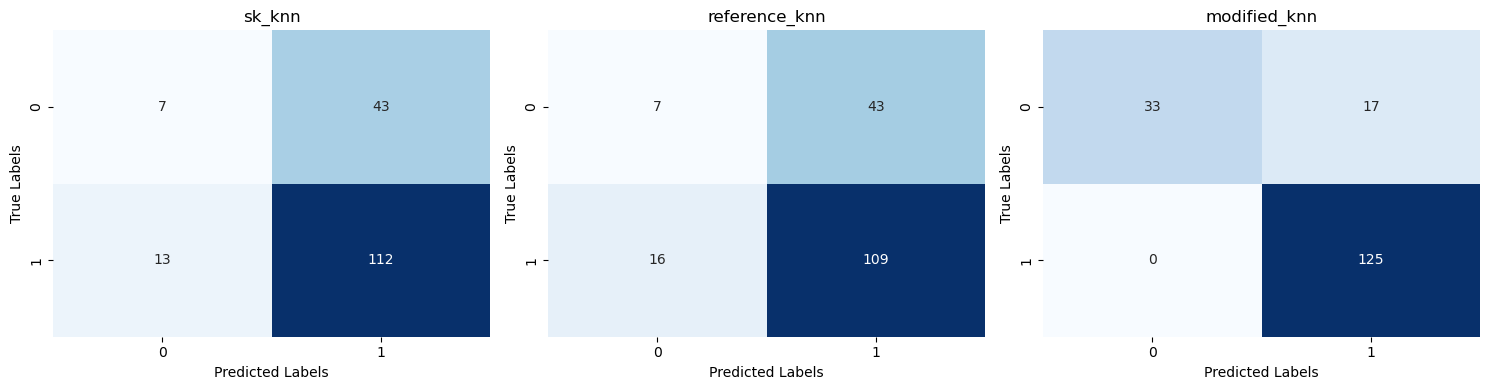

In [66]:
df = pd.read_csv('../csv_files/dataset_9971.csv')
categorical_columns = [column for column in df.columns if df[column].dtype == object]
for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column)  
    df = pd.concat([df, dummies], axis=1)  
df.drop(columns=categorical_columns, inplace=True)

X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sk_knn.fit(X_train, y_train)
reference_knn.fit(X_train, y_train)
modified_knn.fit(X_train, y_train)

y_pred_sk = sk_knn.predict(X_test)
y_pred_ref = reference_knn.predict(X_test)
y_pred_mod = modified_knn.predict(X_test)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_confusion_matrix(y_test, y_pred_sk, ax=axes[0])
axes[0].set_title("sk_knn")

plot_confusion_matrix(y_test, y_pred_ref, ax=axes[1])
axes[1].set_title("reference_knn")

plot_confusion_matrix(y_test, y_pred_mod, ax=axes[2])
axes[2].set_title("modified_knn")

plt.tight_layout()
plt.show()

### Dataset 10101

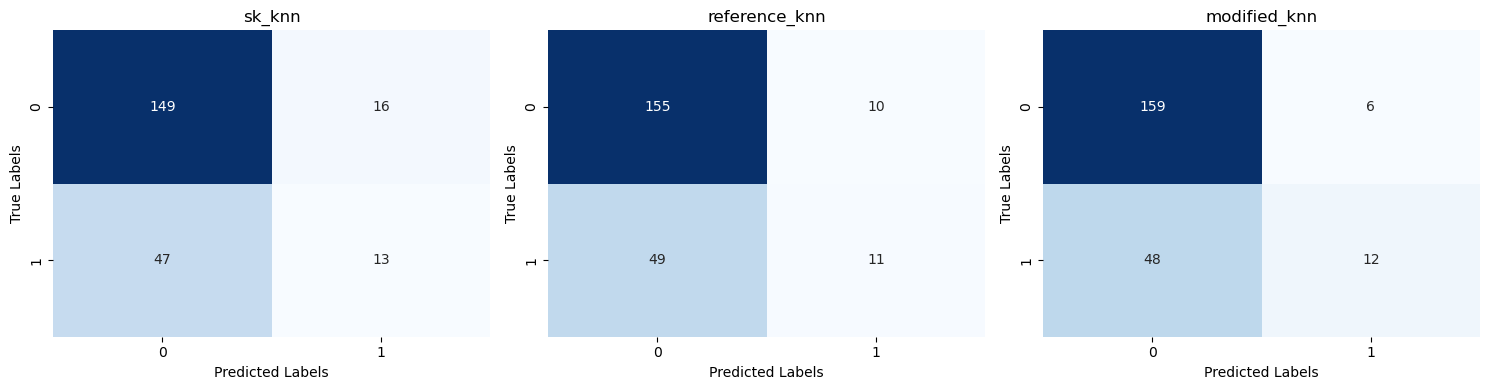

In [67]:
df = pd.read_csv('../csv_files/dataset_10101.csv')

categorical_columns = [column for column in df.columns if df[column].dtype == object]
for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column)  
    df = pd.concat([df, dummies], axis=1)  
df.drop(columns=categorical_columns, inplace=True)

X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

sk_knn.fit(X_train, y_train)
reference_knn.fit(X_train, y_train)
modified_knn.fit(X_train, y_train)

y_pred_sk = sk_knn.predict(X_test)
y_pred_ref = reference_knn.predict(X_test)
y_pred_mod = modified_knn.predict(X_test)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_confusion_matrix(y_test, y_pred_sk, ax=axes[0])
axes[0].set_title("sk_knn")

plot_confusion_matrix(y_test, y_pred_ref, ax=axes[1])
axes[1].set_title("reference_knn")

plot_confusion_matrix(y_test, y_pred_mod, ax=axes[2])
axes[2].set_title("modified_knn")

plt.tight_layout()
plt.show()